0
Iteration :  0
Error:  1.0094532403480665
Mean absolute error for all iterations:  1.0094532403480665


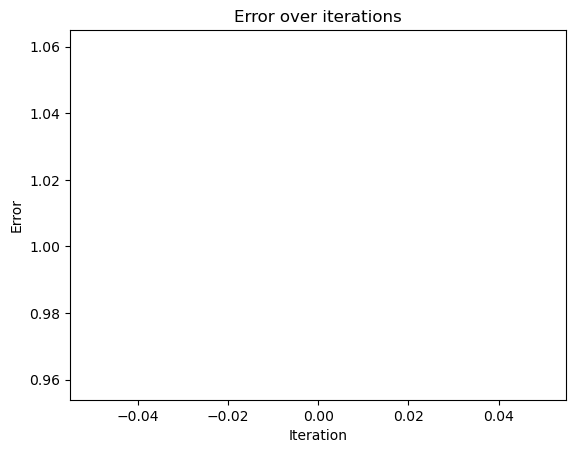

3.173027989821883
---------------------------------


In [2]:
actual =[]
predicated=[]
f1_=[]
precison_g=[]
genetic_error=[]
recall_g=[]
mae_g=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim
from genetic import genetic_optimize, cost_function
from Flowe_2 import flower_pollination_algorithm, cost_function;
from flower import flower_pollination_optimize, cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=5
NO_OF_NEIGHBOURS=10

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)


def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1])))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]
prev=0
actual =[]
predicated=[]
# Train model for given iterations
for i in range(0, 1):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    
    curr=(i+1)*5*10
    active_users = top_users[prev:curr]
    prev=curr

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:34]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)
    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)
    actual=actual_ratings
    predicated=predicated_ratings
    # Get error for predictions of test users
    cur_error = cost_function(actual_ratings, predicated_ratings)

    # Optimize weights using genetic algorithm approach and update weighs
    WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    #WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))
genetic_error=model_error 
f1_=f
precison=pre
recall=re
mae=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
print("---------------------------------")
pred=[int(num) for num in predicated_ratings]





# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list
# 1.0094532403480665

In [16]:
POPULATION_SIZE = 50
SWITCH_PROBABILITY = 0.4
MAX_GENERATIONS = 500
FEATURE_LENGTH = 21

def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using flower pollination method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms

def flower_pollination_optimize(actual_ratings, predicted_ratings):
    """Get feature weights using flower pollination method."""
    # Generate initial population
    
    population = np.random.randint(2, size=(POPULATION_SIZE, FEATURE_LENGTH))
    fitness_vector = np.zeros(POPULATION_SIZE)

    for _ in range(MAX_GENERATIONS):
        print(cost_function(actual_ratings, predicted_ratings))
        for i in range(POPULATION_SIZE):
            if np.random.random() < SWITCH_PROBABILITY:
                # Global pollination
                k, j = np.random.choice(range(POPULATION_SIZE), 2, replace=False)
                new_solution = population[i] + np.random.normal(size=FEATURE_LENGTH) * (population[k] - population[j])
            else:
                # Local pollination
                new_solution = population[i] + np.random.normal(size=FEATURE_LENGTH) * (population[i] - np.mean(population, axis=0))

            # Apply bounds
            new_solution = np.clip(new_solution, 0, 1)

            # Evaluate new solution
            new_fitness = cost_function(actual_ratings, predicted_ratings)

            # If the new solution is better, update the solution
            if new_fitness < fitness_vector[i]:
                population[i] = new_solution
                fitness_vector[i] = new_fitness

    # Return the best solution
    best_solution = population[np.argmin(fitness_vector)]
    return best_solution


In [17]:
flower_pollination_optimize(actual,predicated)

3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.43611

3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111


array([1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])

0
[3, 5, 4, 4, 4, 5, 3, 4, 4, 5, 3, 5, 1, 5, 5, 4, 4, 4, 3, 2, 3, 3, 5, 5, 2, 3, 5, 5, 3, 5, 3, 2, 4, 3, 4, 1, 5, 5, 4, 5, 5, 4, 3, 5, 3, 5, 2, 4, 4, 4, 3, 5, 3, 5, 3, 3, 5, 4, 5, 3, 4, 4, 4, 2, 1, 4, 5, 5, 2, 2, 2, 4, 4, 5, 5, 3, 3, 5, 5, 3, 4, 4, 4, 1, 5, 2, 1, 4, 5, 5, 5, 3, 2, 4, 3, 5, 4, 3, 4, 5, 5, 2, 5, 5, 5, 5, 4, 4, 5, 5, 3, 5, 3, 4, 5, 3, 5, 3, 3, 3, 5, 3, 4, 5, 4, 4, 5, 4, 4, 4, 5, 2, 5, 4, 5, 4, 4, 5, 5, 5, 4, 2, 2, 3, 3, 1, 5, 3, 5, 1, 2, 4, 4, 5, 1, 5, 1, 1, 1, 1, 3, 3, 1, 2, 2, 1, 3, 5, 5, 5, 3, 5, 5, 5, 5, 3, 2, 5, 4, 4, 3, 4, 5, 4, 5, 5, 4, 4, 5, 5, 5, 3, 5, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 3, 1, 2, 2, 2, 1, 2, 5, 4, 3, 3, 4, 3, 4, 2, 5, 4, 5, 4, 2, 2, 4, 4, 3, 2, 5, 3, 5, 3, 4, 5, 3, 2, 2, 5, 2, 1, 4, 4, 1, 5, 3, 3, 3, 4, 3, 4, 5, 5, 4, 4, 2, 3, 3, 5, 4, 3, 3, 5, 4, 5, 4, 2, 5, 2, 5, 4, 3, 3, 3, 1, 5, 5, 4, 4, 4, 4, 4, 2, 4, 5, 5, 4, 5, 4, 4, 3, 5, 2, 5, 4, 5, 5, 3, 3, 3, 3, 2, 5, 1, 5, 4, 5, 5, 4, 5, 4, 4, 4, 3, 2, 4, 5, 3, 4, 1, 3, 3, 1, 4, 5, 3, 5, 5, 3, 1, 4, 3, 4

3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.43611

3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
3570.436111111111
Iteration :  0
Error:  3570.436111111111
1
[4, 3, 2, 3, 2, 4, 1, 4, 5, 4, 4, 5, 2, 4, 3, 4, 3, 5, 5, 3, 3, 3, 5, 5, 4, 5, 3, 5, 4, 5, 4, 3, 3, 3, 5, 2, 3, 4, 3, 4, 3, 4, 5, 5, 3, 4, 3, 4, 2, 5, 1, 4, 3, 4, 3, 2, 4, 4, 4, 4, 1, 3, 3, 4, 5, 4, 2, 3, 4, 3, 4, 3, 2, 4, 3, 2, 4, 2, 3, 3, 4, 4, 5, 5, 4, 5, 1, 5, 5, 5, 4, 4, 4, 3, 4, 3, 5, 4, 4, 4, 3, 3, 4, 2, 2, 3, 2, 1, 2, 3, 2, 4, 2, 3, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 4, 3, 4, 5, 5, 4, 3, 5, 2, 5, 5, 5, 4, 5, 4, 4, 5, 4, 5, 4, 4, 5, 5, 4, 5, 5, 4, 4, 5, 3, 2, 4, 3, 5, 5, 2, 3, 4, 3, 4, 5, 4, 4, 4, 4, 3, 4, 2, 3, 3, 1, 5, 1, 4, 4, 3, 5, 4, 5, 4, 3, 4, 5, 5, 3, 3, 4, 4, 5, 3, 1, 2, 3, 4, 4, 1, 3, 5, 5, 5, 1, 5, 5, 4,

4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317

4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317460313
4015.5960317

1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571

1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
1753.8428571428567
Iteration :  2
Error:  1753.8428571428567
3
[5, 4, 3, 2, 3, 3, 2, 5, 4, 4, 5, 3, 4, 3, 2

1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555

1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
1339.2305555555558
Iteration :  3
Error:  1339.2305555555558
4
[4, 5, 3, 5, 5, 4, 2, 5, 3, 5, 4, 4, 3, 5, 2, 3, 4, 5, 2, 5, 5, 3, 4, 4, 5, 5, 2, 2, 5, 4, 3, 4, 5, 5, 1, 4, 4, 4, 4, 4, 3, 4, 4, 2, 3, 4, 4, 3, 4, 2, 1, 2, 5, 1, 5, 5, 5, 2, 4, 3, 5, 4, 5, 5, 5, 3, 4, 3, 5, 5, 4, 3, 4, 1, 4, 5, 1, 1, 1, 4, 3, 5, 3, 2, 3, 3, 3, 4, 5, 5, 4

975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.9333333333336
975.933333

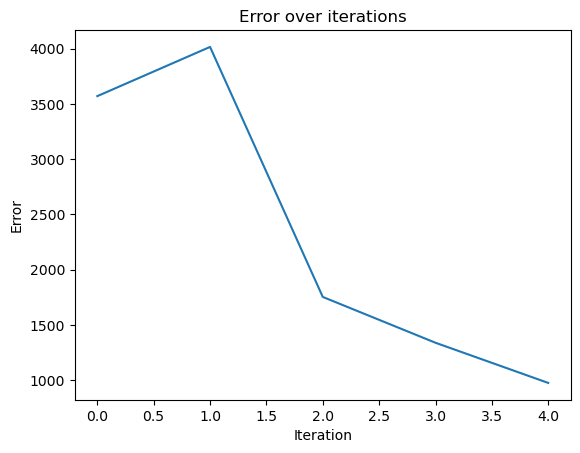

3.674440298507463
---------------------------------


In [38]:

f1_=[]
precison_g=[]
genetic_error=[]
recall_g=[]
mae_g=[]

from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
# Import pandas and numpy
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt

from settings import NO_OF_GENRES, NO_OF_FEATURES
import load_data
import fuzzy_sets
import gim

# from Flowe_2 import flower_pollination_algorithm, cost_function;
# from flower import flower_pollination_optimize, cost_function
# from Flowe import flower_pollination_optimize,cost_function
# Constants
WEIGHTS=np.random.rand(NO_OF_FEATURES)
NO_OF_ITERATIONS=5
NO_OF_NEIGHBOURS=1000

# namespace items_merged from load_data file
items_merged = load_data.items_merged

# Create objects for Age and GIM to use for fuzzy sets
age = fuzzy_sets.Age()
gim_obj = fuzzy_sets.GIM()

m_cols = ['unknown', 'Action', 'Adventure',
          'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
          'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'age',
          'user_id']

# Initialize empty dataFrames for active and passive users
model_data_active_users = pd.DataFrame(columns=m_cols)
model_data_passive_users = pd.DataFrame(columns=m_cols)
def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using flower pollination method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms 

def euclidean_dist(list_a, list_b):
    """Return the Euclidean distance between two array elements."""
    return np.linalg.norm(np.array(list_a) - np.array(list_b))


def fuzzy_dist(first_point, second_point, fuzzy_set_first_point, fuzzy_set_second_point):
    """Returns fuzzy distance between two values and their fuzzy sets."""
    return abs(first_point - second_point) * euclidean_dist(fuzzy_set_first_point, fuzzy_set_second_point)


def fuzzy_distance(ui, uj):
   
  
    """Returns fuzzy distance between given points."""

    fuzzy_dis = [0] * NO_OF_FEATURES

    # Get fuzzy set values for movie genres
    for i in range(0, NO_OF_GENRES):

        ui_gim = gim_obj.get_fuzzy_set(int(ui.iloc[i]))
        uj_gim = gim_obj.get_fuzzy_set(int(uj.iloc[i]))
        fuzzy_dis[i] =fuzzy_dist(int(ui.iloc[i]), int(uj.iloc[i]), ui_gim, uj_gim)

    # Get fuzzy set values for age
    ui_gim = age.get_fuzzy_set(int(ui.iloc[i]))
    uj_gim = age.get_fuzzy_set(int(uj.iloc[i]))  # specify the column name here
    fuzzy_dis[i] = fuzzy_dist(int(ui.iloc[i]),int(uj.iloc[i]), ui_gim, uj_gim)

    # adding user_id of second user
    fuzzy_dis[NO_OF_FEATURES-1] = uj['user_id']
    
    return fuzzy_dis


def get_neighbours(model_active_users, model_passive_users):
    # Save active users and its neighbours in a data-frame with active users' id as column name
    user_neighbours= pd.DataFrame(columns=model_active_users['user_id'])
    #print("user",user_neighbours)
    # Iterate over active users model and save neighbours of each active users in user_neighbours
    for _, value in model_active_users.iterrows():
        j = 0
        fuzzy_vec = []
        for _, value_p in model_passive_users.iterrows():
            fuzzy_vec.append(fuzzy_distance(value, value_p))
            #print("fuzzy_vec",fuzzy_vec)
            #print(WEIGHTS[:-1])
            fuzzy_gen_dist = np.abs(np.sum(np.multiply(WEIGHTS[:-1], np.array(fuzzy_vec[j][:-1]))))
            fuzzy_vec[j] = [fuzzy_gen_dist, fuzzy_vec[j][-1]]
            j = j + 1
        user_neighbours[value.iloc[-1]] = [n[1] for n in sorted(fuzzy_vec, key=operator.itemgetter(0), reverse=True)][:NO_OF_NEIGHBOURS]
    return user_neighbours


def model_for_users(users_data):
    """Create model for given users data i.e. merged movies, items, and users
    Args:
        users_data: DataFrame of merged movies, items, and users based on movie_id
    """
    i = 0
    model_data_for_users = pd.DataFrame(columns=m_cols)
    
    for _, curr_value in users_data.iterrows():
        #print(curr_value)
        # Get user movies based on user
        user_movies = items_merged.loc[items_merged['user_id'] == curr_value['user_id']]
        #print("user movie",user_movies)
        # Get feature list for all movies of one user
        feature_array = gim.gim_final(user_movies, curr_value['user_id'])
        feature_array[NO_OF_GENRES] = curr_value['age']
        feature_array[NO_OF_GENRES + 1] = curr_value['user_id']

        # Save current feature values in model data
        model_data_for_users.loc[i] = feature_array
        i = i + 1
    return model_data_for_users

def correction_prediction(actual_ratings, predicted_ratings):
    """Correct predicted ratings based on actual ratings."""

    # Compute errors between actual and predicted ratings
    errors =errors = [actual - predicted for actual, predicted in zip(actual_ratings, predicted_ratings)]

    # Calculate mean error
    mean_error = np.mean(errors)

    # Apply correction to predicted ratings
    corrected_predictions = np.array([predicted_rating + mean_error for predicted_rating in predicted_ratings])

    return corrected_predictions
def recommend(nearest_neighbours, test_users_data):
    """Recommend rating for given movies i.e. test_examples based on nearest neighbours.
     
    Also return actual and predicated ratings for testing users
    """
    # print("nearest_neighbours")
    # print(nearest_neighbours)
    # print("test_users_data")
    # print(test_users_data.head())
    predicated_rat=[]
    actual_rat = []
    for key, item in test_users_data.iterrows():
        #print(item)
        
        m_id = item['movie_id']
        n_ratings = []
        for i in nearest_neighbours:

            # Get items or movie details reviewed by neighbour i with given m_id
            temp = items_merged.loc[items_merged['user_id'] == i].loc[items_merged['movie_id'] == m_id]
            for k, it in temp.iterrows():
                n_ratings.append(it['rating'])
        predicated_rat.append(float(sum(n_ratings)) / len(n_ratings) if len(n_ratings) else 0)
        actual_rat.append(item['rating'])
    return actual_rat, predicated_rat

# Users who has rated movies at least 60 movies
top_users = load_data.items_merged.groupby('user_id').size().sort_values(ascending=False)[:497]
 
model_error = []
f=[]
re=[]
pre=[]
prev=0


# Train model for given iterations
for i in range(0, 5):
    print(i)

    # Get random 10% of the top_users as active users and remaining are passive users
    
    curr=(i+1)*5*10
    active_users = top_users[prev:curr]
    prev=curr

    # Random 34% of active users will be used for training and 66% users for testing purpose.
    training_active_users = active_users[:34]
    #testing_active_users = active_users.drop(training_active_users.index)

    # passive_users will be used as training examples
    passive_users = top_users.drop(active_users.index)

    # Get active and passive users' data from merged movies, items, and users
    training_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][:10]
    test_active_users_data = items_merged.loc[items_merged['user_id'].isin(training_active_users)][10:]
    passive_users_data = items_merged.loc[items_merged['user_id'].isin(passive_users)][:10]

    # Get model for active users
    model_data_active_users = model_for_users(training_active_users_data)

    # Get model for passive users
    model_data_passive_users = model_for_users(passive_users_data)

    # Get neighbour users of active users
    active_users_neighbours = get_neighbours(model_data_active_users, model_data_passive_users)

    # Recommend users based on neighbours
    actual_ratings, predicated_ratings=recommend(active_users_neighbours, test_active_users_data)
    print(actual_ratings)
    print(predicated_ratings)
    # Get error for predictions of test users
    

    # Optimize weights using genetic algorithm approach and update weighs
    #WEIGHTS  =genetic_optimize(actual_ratings, predicated_ratings).flatten()
    # print(predicated_ratings)
    
    
    WEIGHTS  =flower_pollination_optimize(actual_ratings, predicated_ratings).flatten()
    cur_error = cost_function(actual_ratings, predicated_ratings)
    # Add current iteration error to model error for MAE of the model
    
    model_error.append(cost_function(actual_ratings, predicated_ratings))
    pred=[int(num) for num in predicated_ratings]
    f.append(f1_score(actual_ratings, pred, average='micro'))
    pre.append(precision_score(actual_ratings, pred, average='micro'))
    re.append(recall_score(actual_ratings, pred, average='micro'))
    # Log details for current iteration
    print("Iteration : ", i)
    print("Error: ", cur_error)
   
print("Mean absolute error for all iterations: ", sum(model_error)/len(model_error))
genetic_error=model_error 
f1_=f
precison=pre
recall=re
mae=model_error
#average of erro overt the time 
plt.plot(model_error)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error over iterations')
plt.show()
print(np.mean(correction_prediction(actual_ratings, predicated_ratings)))
print("---------------------------------")
pred=[int(num) for num in predicated_ratings]





# Assuming model_error is your list
# replace with your list

# Assuming model_error is your list
# replace with your list
# 1.0094532403480665



In [ ]:
POPULATION_SIZE = 50
SWITCH_PROBABILITY = 0.8
MAX_GENERATIONS = 500
FEATURE_LENGTH = 21

def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using flower pollination method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms / len(actual_ratings)

def flower_pollination_optimize(actual_ratings, predicted_ratings):
   
    """Get feature weights using flower pollination method."""

    # Generate initial population
    population = np.random.randint(2, size=(POPULATION_SIZE, FEATURE_LENGTH))
    fitness_vector = np.zeros(POPULATION_SIZE)

    for _ in range(MAX_GENERATIONS):
        print(cost_function(actual_ratings, predicted_ratings))
        for i in range(POPULATION_SIZE):
            if np.random.random() < SWITCH_PROBABILITY:
                # Global pollination
                k, j = np.random.choice(range(POPULATION_SIZE), 2, replace=False)
                new_solution = population[i] + np.random.normal() * (population[k] - population[j])
            else:
                # Local pollination
                new_solution = population[i] + np.random.normal() * (population[i] - np.mean(population, axis=0))

            # Apply bounds
            new_solution = np.clip(new_solution, 0, 1)

            # Evaluate new solution
            new_fitness = cost_function(actual_ratings, predicted_ratings)

            # If the new solution is better, update the solution
            if new_fitness < fitness_vector[i]:
                population[i] = new_solution
                fitness_vector[i] = new_fitness

    # Return the best solution
    best_solution = population[np.argmin(fitness_vector)]
    return best_solution

In [19]:
def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using flower pollination method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms

In [18]:
import numpy  as np
import math
import random
import os
from scipy.special import gamma

# Function
def target_function():
    return

# Function: Initialize Variables
def initial_position(flowers = 3, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    position = np.zeros((flowers, len(min_values)+1))
    for i in range(0, flowers):
        for j in range(0, len(min_values)):
             position[i,j] = random.uniform(min_values[j], max_values[j])
        position[i,-1] = target_function(position[i,0:position.shape[1]-1])
    return position

#Function Levy Distribution
def levy_flight(beta = 1.5):
    beta    = beta  
    r1      = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
    r2      = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
    sig_num = gamma(1+beta)*np.sin((np.pi*beta)/2.0)
    sig_den = gamma((1+beta)/2)*beta*2**((beta-1)/2)
    sigma   = (sig_num/sig_den)**(1/beta)
    levy    = (0.01*r1*sigma)/(abs(r2)**(1/beta))
    return levy

# Function: Global Pollination
def pollination_global(position, best_global, flower = 0, gama = 0.5, lamb = 1.4, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    x = np.copy(best_global)
    for j in range(0, len(min_values)):
        x[j] = np.clip((position[flower, j]  + gama*levy_flight(lamb)*(position[flower, j] - best_global[j])),min_values[j],max_values[j])
    x[-1]  = target_function(x[0:len(min_values)])
    return x

# Function: Local Pollination
def pollination_local(position, best_global, flower = 0, nb_flower_1 = 0, nb_flower_2 = 1, min_values = [-5,-5], max_values = [5,5], target_function = target_function):
    x = np.copy(best_global)
    for j in range(0, len(min_values)):
        r = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
        x[j] = np.clip((position[flower, j]  + r*(position[nb_flower_1, j] - position[nb_flower_2, j])),min_values[j],max_values[j])
    x[-1]  = target_function(x[0:len(min_values)])
    return x

# FPA Function.
def flower_pollination_algorithm(flowers = 3, min_values = [-5,-5], max_values = [5,5], iterations = 50, gama = 0.5, lamb = 1.4, p = 0.8, target_function = target_function):    
    count    = 0
    position = initial_position(flowers = flowers, min_values = min_values, max_values = max_values, target_function = target_function)
    best_global = np.copy(position[position[:,-1].argsort()][0,:])
    x = np.copy(best_global)   
    while (count <= iterations):
        print("Iteration = ", count, " f(x) = ", best_global[-1])
        for i in range(0, position.shape[0]):
            nb_flower_1 = int(np.random.randint(position.shape[0], size = 1))
            nb_flower_2 = int(np.random.randint(position.shape[0], size = 1))
            while nb_flower_1 == nb_flower_2:
                nb_flower_1 = int(np.random.randint(position.shape[0], size = 1))
            r = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
            if (r < p):
                x = pollination_global(position, best_global, flower = i, gama = gama, lamb = lamb, min_values = min_values, max_values = max_values, target_function = target_function)
            else:
                x = pollination_local(position, best_global, flower = i, nb_flower_1 = nb_flower_1, nb_flower_2 = nb_flower_2, min_values = min_values, max_values = max_values, target_function = target_function)
            if (x[-1] <= position[i,-1]):
                for j in range(0, position.shape[1]):
                    position[i,j] = x[j]
            value = np.copy(position[position[:,-1].argsort()][0,:])
            if (best_global[-1] > value[-1]):
                best_global = np.copy(value) 
        count = count + 1       
    print(best_global)    
    return best_global


In [20]:
flower_pollination_algorithm(flowers = 175, min_values = [-5,-5], max_values = [5,5], iterations = 1000, gama = 0.1, lamb = 1.5, p = 0.8, target_function =cost_function(actual,predicated))

TypeError: 'numpy.float64' object is not callable

In [24]:
import os
import random
import numpy as np
from scipy.special import gamma

# Define your target function here (replace it with your actual target function)
matrix1 = np.array(actual)
matrix2 = np.array(predicated)
def target_function(x):
    # Assuming matrix1 and matrix2 are the matrices you want to minimize the difference between
    matrix1 = np.array(actual)  # Replace with your actual matrix1
    matrix2 = np.array(predicated) # Replace with your actual matrix2
    difference_matrix = matrix1 - x[0] * (matrix1 - matrix2)
    return np.linalg.norm(difference_matrix, 'fro')  # Frobenius norm

def initial_position(flowers=3, min_values=[0], max_values=[1], target_function=target_function):
    position = np.zeros((flowers, len(min_values) + 1))
    for i in range(flowers):
        for j in range(len(min_values)):
            position[i, j] = random.uniform(min_values[j], max_values[j])
        position[i, -1] = target_function(position[i, 0:position.shape[1] - 1])
    return position

def levy_flight(beta=1.5):
    beta = beta
    r1 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    r2 = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
    sig_num = gamma(1 + beta) * np.sin((np.pi * beta) / 2.0)
    sig_den = gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2)
    sigma = (sig_num / sig_den) ** (1 / beta)
    levy = (0.01 * r1 * sigma) / (abs(r2) ** (1 / beta))
    return levy

def pollination_global(position, best_global, flower=0, gama=0.5, lamb=1.4, min_values=[0], max_values=[1], target_function=target_function):
    x = np.copy(best_global)
    for j in range(len(min_values)):
        x[j] = np.clip((position[flower, j] + gama * levy_flight(lamb) * (position[flower, j] - best_global[j])),
                       min_values[j], max_values[j])
    x[-1] = target_function(x[0:len(min_values)])
    return x

def pollination_local(position, best_global, flower=0, nb_flower_1=0, nb_flower_2=1, min_values=[0], max_values=[1], target_function=target_function):
    x = np.copy(best_global)
    for j in range(len(min_values)):
        r = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
        x[j] = np.clip((position[flower, j] + r * (position[nb_flower_1, j] - position[nb_flower_2, j])),
                       min_values[j], max_values[j])
    x[-1] = target_function(x[0:len(min_values)])
    return x

def flower_pollination_algorithm(flowers=3, min_values=[0], max_values=[1], iterations=50, gama=0.5, lamb=1.4, p=0.8, target_function=target_function):
    count = 0
    position = initial_position(flowers=flowers, min_values=min_values, max_values=max_values,
                                target_function=target_function)
    best_global = np.copy(position[position[:, -1].argsort()][0, :])
    x = np.copy(best_global)
    while count <= iterations:
        print("Iteration = ", count, " f(x) = ", best_global[-1])
        for i in range(position.shape[0]):
            nb_flower_1 = int(np.random.randint(position.shape[0], size=1))
            nb_flower_2 = int(np.random.randint(position.shape[0], size=1))
            while nb_flower_1 == nb_flower_2:
                nb_flower_1 = int(np.random.randint(position.shape[0], size=1))
            r = int.from_bytes(os.urandom(8), byteorder="big") / ((1 << 64) - 1)
            if r < p:
                x = pollination_global(position, best_global, flower=i, gama=gama, lamb=lamb,
                                        min_values=min_values, max_values=max_values, target_function=target_function)
            else:
                x = pollination_local(position, best_global, flower=i, nb_flower_1=nb_flower_1,
                                       nb_flower_2=nb_flower_2, min_values=min_values, max_values=max_values,
                                       target_function=target_function)
            if x[-1] <= position[i, -1]:
                for j in range(position.shape[1]):
                    position[i, j] = x[j]
                value = np.copy(position[position[:, -1].argsort()][0, :])
                if best_global[-1] > value[-1]:
                    best_global = np.copy(value)
        count = count + 1
    print(best_global)
    return best_global

# Example usage:
result = flower_pollination_algorithm(flowers=3, min_values=[0], max_values=[1], iterations=50)


ValueError: Invalid norm order 'fro' for vectors

In [32]:
import numpy as np

# Constants
INITIAL_POPULATION=50
MUTATION_RATE=0.08
NUM_OF_GENERATIONS=10000
FEATURE_LENGTH=21
WINNER_PER_GEN=5


def cost_function(actual_ratings, predicted_ratings):
    """Cost function to optimize using genetic method."""
    ms = sum(abs(np.array(predicted_ratings) - np.array(actual_ratings)))
    return ms / len(actual_ratings)


def genetic_optimize(actual_ratings, predicted_ratings):
    """Get genetic feature weights using crossover and mutation."""

    # Generate initial binary population
    cur_gen_pop = np.random.randint(2, size=(INITIAL_POPULATION, FEATURE_LENGTH))
    next_gen_pop = np.zeros((cur_gen_pop.shape[0], cur_gen_pop.shape[1]))
    fitness_vector = np.zeros((INITIAL_POPULATION, 2))

    for i in range(NUM_OF_GENERATIONS):
        print(cost_function(actual_ratings,predicted_ratings))

        fitness_vector = np.array([np.array([x, cost_function(actual_ratings, predicted_ratings)]) for x in range(INITIAL_POPULATION)])
        # e.g. [0, 0.11] means that the 0th element in cur_gen_pop (first solution) has an error of 0.11

        # create a winners array of size winner*solution
        winners = np.zeros((WINNER_PER_GEN, FEATURE_LENGTH))
        for n in range(len(winners)):
            selected = np.random.choice(range(len(fitness_vector)), int(WINNER_PER_GEN/2),
                                        replace=False)  # select random indexes from pop

            wnr = np.argmin(fitness_vector[selected, 1])  # select one index with min fitness error (tournament)
            winners[n] = cur_gen_pop[int(fitness_vector[selected[wnr]][0])]  # add to winner population

        next_gen_pop[:len(winners)] = winners  # populate new gen with winners

        # mating using crossover via permutation
        next_gen_pop[len(winners):] = np.array(
            [np.array(
                np.random.permutation(np.repeat(winners[:, x], ((INITIAL_POPULATION - len(winners)) / len(winners)), axis=0)))
             for x in range(winners.shape[1])]).T  # Populate the rest of the generation with offspring of mating pairs

        # random mutation
        next_gen_pop = np.multiply(next_gen_pop, np.matrix(
            [np.float64(np.random.normal(0, 2, 1)) if np.random.random() < MUTATION_RATE else 1 for x in
             range(next_gen_pop.size)]).reshape(next_gen_pop.shape))
        cur_gen_pop = next_gen_pop

    best_soln = np.array(cur_gen_pop[np.argmin(fitness_vector[:, 1])])
    return best_soln


In [33]:
genetic_optimize(actual,predicated)

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403480665
1.0094532403

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.29609072e-12,  2.42841186e+18, -1.05536866e+15,
        -5.94957792e+21,  5.22963402e+17,  1.22740817e+13,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         4.29991338e-02,  3.05359499e-01, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])